<p p style = "font-family: garamond; font-size:40px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">G2Net Gravitational Waves</p>

![](https://www.g2net.eu/wp-content/uploads/2019/07/2ndconference_V2-1170x600.jpg)



<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#006699; border-radius: 10px 10px; text-align:center"> 
The breakthrough discovery of gravitational waves on September 14, 2015 was made possible through synergy of techniques drawing from expertise in physics, mathematics, information science and computing. In this competition you are provided with a training set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo). Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal.</p>

<center><img src="https://www.phys.ufl.edu/wp/wp-content/uploads/2020/09/image.png" width="1000" alt="Weights & Biases" /></center><br>

<p p style = "font-family: garamond; font-size:40px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">What are we discussing today? </p>
 <p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#006699; border-radius: 10px 10px; text-align:center"> Constant Q Transform<br>
 DeepSpeed Fused Adam optimizer <br>
 Pytorch Lightning <br>
 Stratified K-Fold with PL ⚡️ <br>
 Weights and Biases for Experiment Tracking including W&B Tables

<p p style = "font-family: garamond; font-size:35px; font-style: normal;background-color: #f6f5f5; color :#ff0066; border-radius: 10px 10px; text-align:center">Upvote the kernel if you find it insightful!</p>

In [ ]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

<center><img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" /></center><br>
<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center">Wandb is a developer tool for companies turn deep learning research projects into deployed software by helping teams track their models, visualize model performance and easily automate training and improving models.
We will use their tools to log hyperparameters and output metrics from your runs, then visualize and compare results and quickly share findings with your colleagues.<br><br>We'll be using this to train our K Fold Cross Validation and gain better insights about our training. <br><br></p>

![img](https://i.imgur.com/BGgfZj3.png)

In [ ]:
!pip install --upgrade -q wandb
!pip install -q pytorch-lightning
!pip install -q nnAudio
!pip install -q deepspeed
!pip install -q timm

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Import Libraries</p>

In [ ]:
# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import random
import glob
import math


# Visualizations
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Utilities and Metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.optimizer import Optimizer, required 
from pytorch_lightning.plugins import DeepSpeedPlugin
from deepspeed.ops.adam import FusedAdam


# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

# Pytorch Image Models
import timm

# Image Augmentation Library
import albumentations
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

from nnAudio.Spectrogram import CQT2010v2, MFCC, CQT1992v2, MelSpectrogram


# Weights and Biases Tool
import wandb
wandb.login()

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Define Configurations/Parameters</p>

In [ ]:
params = {
    'seed': 42,
    'model': 'efficientnet_b1',
    'size' : 224,
    'inp_channels': 1,
    'lr': 1e-3,
    'weight_decay': 1e-6,
    'batch_size': 64,
    'num_workers' : 8,
    'epochs': 5,
    'out_features': 1,
    'name': 'CosineAnnealingLR',
    'T_max': 10,
    'min_lr': 1e-6,
    'nfolds': 5,
    'precision': 16,
    'competetion': 'G2Net',
    '_wandb_kernel':'tang'
}

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Define Seed for Reproducibility</p>

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(params['seed'])

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Load Train and Test</p>

In [ ]:
train_dir = ('../input/g2net-gravitational-wave-detection/train')
test_dir = ('../input/g2net-gravitational-wave-detection/test')
train_df = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
test_df = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

In [ ]:
def return_filpath(name, folder=train_dir):
    path = os.path.join(folder, f'{name[0]}/{name[1]}/{name[2]}/{name}.npy')
    return path

In [ ]:
train_df['image_path'] = train_df['id'].apply(lambda x: return_filpath(x))
test_df['image_path'] = test_df['id'].apply(lambda x: return_filpath(x, folder=test_dir))
train_df.head()

In [ ]:
train_df = train_df.sample(n=50000, random_state=params['seed']).reset_index(drop=True)

<center><img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" /></center><br>
<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center">W&B Tables accelerate the ML development lifecycle by giving users the ability to rapidly extract meaningful insights from data. The W&B Table Visualizer provides an interactive interface to perform powerful analytics functions like grouping, joining, and creating custom fields while simultaneously supporting rich media annotations such as bounding boxes and segmentation masks.<br><br> W&B Tables is designed generically to work well for a wide range of use cases - from analyzing intermediate data transformations to reviewing model predictions - while being directly integrated directly into the WB UI dashboard, allowing users to learn, adapt, and improve their models effectively and efficiently.</p>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Constant Q Transform</p>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> In mathematics and signal processing, the constant-Q transform, simply known as CQT transforms a data series to the frequency domain. It is related to the Fourier transform[1] and very closely related to the complex Morlet wavelet transform.<br><br> An efficient method of transforming a discrete Fourier transform (DFT) into a constant Q transform, where Q is the ratio of center frequency to bandwidth, has been devised. This method involves the calculation of kernels that are then applied to each subsequent DFT. Only a few multiples are involved in the calculation of each component of the constant Q transform, so this transformation adds a small amount to the computation. In effect, this method makes it possible to take full advantage of the computational efficiency of the fast Fourier transform (FFT).

In [ ]:
run = wandb.init(project='G2Net-PL-Baseline', 
                           config=params,
                           group='Effnet-CQT', 
                           job_type='Visualize')

sample_data_tables = wandb.Table(columns=["ID","CQT", "target"])


def apply_qtransform(waves, transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)):
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    return image


for i in range(10):
    waves = np.load(train_df.loc[i, 'image_path'])
    image = apply_qtransform(waves)
    target = train_df.loc[i, 'target']
    sample_data_tables.add_data(train_df.loc[i, 'id'],
                                wandb.Image(image),
                                target)
    
    

wandb.log({'wandb_viz': sample_data_tables})    
wandb.finish()


<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">W&B Table for CQT Visualization</p><br>

<center><img src="https://i.imgur.com/GwOF2DS.png" width="1500" alt="metrics" /></center>

In [ ]:
dist = train_df.target.map({0:'Target 0', 1:'Target 1'})
dist = dist.value_counts()
fig = px.pie(dist,
             values='target',
             names=dist.index,
             hole=.4,title="Target Distribution")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Custom Dataset</p>

In [ ]:
def get_train_transforms():
    return albumentations.Compose(
        [

            ToTensorV2(p=1.0)
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                ToTensorV2(p=1.0)
            ]
        )

In [ ]:
class SETIDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform
        self.wave_transform = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64, verbose=True)

    def __len__(self):
        return len(self.images_filepaths)
    
    def apply_cqt(self, image, transform):
        image = np.hstack(image)
        image = image / np.max(image)
        image = torch.from_numpy(image).float()
        image = transform(image)
        return image

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = np.load(image_filepath)
        image = self.apply_cqt(image, self.wave_transform)

        if self.transform is not None:
            image = image.squeeze().numpy()
            image = self.transform(image=image)["image"]
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        label = torch.tensor(self.targets[idx]).float()
        return image, label

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Custom Callback for Viewing Predictions in W&B</p>


In [ ]:
class ImagePredictionLogger(Callback):
    def __init__(self, val_samples = None, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
          
        
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        trainer.logger.experiment.log({
            "Predictions":[wandb.Image(x, caption=f"Pred:{pred}, Target:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            }, commit=False)

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Pytorch Lightning DataModule</p>

# <center>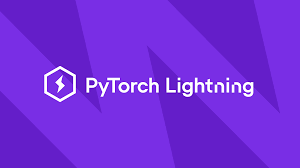</center>


<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> A datamodule is a shareable, reusable class that encapsulates all the steps needed to process data. A datamodule encapsulates the five steps involved in data processing in PyTorch:<br>1. Download / tokenize / process.<br>2. Clean and (maybe) save to disk.<br>3. Load inside Dataset.<br>4. Apply transforms (rotate, tokenize, etc…).<br>5. Wrap inside a DataLoader.<br><br>
📍 Why do I need a DataModule?<br>In normal PyTorch code, the data cleaning/preparation is usually scattered across many files. This makes sharing and reusing the exact splits and transforms across projects impossible.<br>Datamodules are for you if you ever asked the questions:<br>1. what splits did you use?<br>2. what transforms did you use?<br>3. what normalization did you use?<br>4. how did you prepare/tokenize the data?<br><br> To summarize: A DataModule is simply a collection of a train_dataloader, val_dataloader(s), test_dataloader(s) along with the matching transforms and data processing/downloads steps required.

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, train_data, valid_data, test_data):
        super().__init__()
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        
    def setup(self, stage=None):
        self.train_dataset = SETIDataset(
        images_filepaths=self.train_data['image_path'].values,
        targets=self.train_data['target'].values,
        transform = get_train_transforms()    
            )
        
        self.val_dataset = SETIDataset(
        images_filepaths=self.valid_data['image_path'].values,
        targets=self.valid_data['target'].values,
        transform = get_valid_transforms()
        )

        self.test_dataset = SETIDataset(
        images_filepaths = self.test_data['image_path'].values,
        targets = self.test_data['target'].values,
        transform = get_test_transforms()
        )

    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=params['num_workers'],
        pin_memory=True
            )

    def val_dataloader(self):
        return DataLoader(
        self.val_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=params['num_workers'],
        pin_memory=True
            )

    def test_dataloader(self):
        return DataLoader(
        self.test_dataset, batch_size=params['batch_size'],
        shuffle=False, num_workers=params['num_workers'],
        pin_memory=True
            )

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">DeepSpeed Fused Adam Optimizer</p>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> DeepSpeed offers high-performance implementations of Adam optimizer on CPU; FusedAdam, FusedLamb, OnebitAdam, OnebitLamb optimizers on GPU. <br><br> Here we implement Fused Adam which implements Adam algorithm but this version implements 2 fusions.<br><br> 1. Fusion of the Adam update’s elementwise operations. <br>2.A multi-tensor apply launch that batches the elementwise updates applied to all the model’s parameters into one or a few kernel launches.<br><br> The Adam optimizer in Pytorch (like all Pytorch optimizers) carries out optimizer.step() by looping over parameters, and launching a series of kernels for each parameter. This can require hundreds of small launches that are mostly bound by CPU-side Python looping and kernel launch overhead, resulting in poor device utilization. Currently, the FusedAdam implementation in Apex flattens the parameters for the optimization step, then carries out the optimization step itself via a fused kernel that combines all the Adam operations. In this way, the loop over parameters as well as the internal series of Adam operations for each parameter are fused such that optimizer.step() requires only a few kernel launches.

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Pytorch Lightning Module</p>
<center>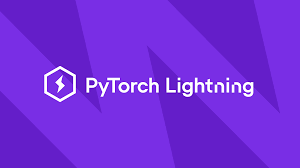</center><br>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> A LightningModule organizes your PyTorch code into 5 sections<br>1. Computations (init).<br>2. Train loop (training_step)<br>3. Validation loop (validation_step)<br>4. Test loop (test_step)<br>5. Optimizers (configure_optimizers)<br><br>
A LightningModule is a torch.nn.Module but with added functionality. 

In [ ]:
class Trainer(pl.LightningModule):

    def __init__(self, model_name=params['model'],out_features=params['out_features'],
                 inp_channels=params['inp_channels'],pretrained=True):
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                       in_chans=inp_channels)
        
        if model_name == 'resnet18d':
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, out_features, bias=True)
            
        if model_name == 'nfnet_f1':
            n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(n_features, out_features, bias=True)
            
        elif model_name == 'efficientnet_b1':
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, out_features, bias=True) 
    
        self.criterion = nn.BCEWithLogitsLoss()
                
    def forward(self, x):
        output = self.model(x)
        return output


    def training_step(self, batch, batch_idx):

        x, y = batch
        output = self.model(x)
        labels = y.unsqueeze(1)
        loss = self.criterion(output, labels)
        
        try:
            auc=roc_auc_score(labels.detach().cpu(), output.sigmoid().detach().cpu()) 

            self.log("auc", auc, on_step= True, prog_bar=True, logger=True)
            self.log("Train Loss", loss, on_step= True,prog_bar=True, logger=True)
        
        except:
            pass

        return {"loss": loss, "predictions": output, "labels": labels}

    def training_epoch_end(self, outputs):

        preds = []
        labels = []
        
        for output in outputs:
            
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        train_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("mean_train_auc", train_auc, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        labels = y.unsqueeze(1)
        loss = self.criterion(output, labels)
        
        self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
        return {"predictions": output, "labels": labels}
      

    def validation_epoch_end(self, outputs):

        preds = []
        labels = []
        
        for output in outputs:
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        val_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("val_auc", val_auc, prog_bar=True, logger=True)
        

    def test_step(self, batch, batch_idx):
        x = batch        
        output = self(x).sigmoid()
        return output   

    def configure_optimizers(self):

        param_optimizer = list(self.model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": params['weight_decay'],
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
    
        optimizer = FusedAdam(optimizer_parameters, lr=params['lr'])
        
        
        scheduler = CosineAnnealingLR(optimizer,
                              T_max=params['T_max'],
                              eta_min=params['min_lr'],
                              last_epoch=-1)

        return dict(
          optimizer=optimizer,
          lr_scheduler=scheduler
        )


<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Pytorch Lightning Trainer</p>

# <center>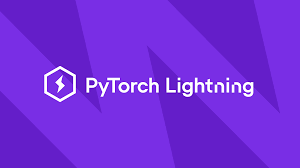</center>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> Once you’ve organized your PyTorch code into a LightningModule, the Trainer automates everything else.<br><br>📍 This abstraction achieves the following:<br><br>1. You maintain control over all aspects via PyTorch code without an added abstraction.<br>2. The trainer uses best practices embedded by contributors and users from top AI labs such as Facebook AI Research, NYU, MIT, Stanford, etc…<br>3. The trainer allows overriding any key part that you don’t want automated.<br><br>
📍 Under the hood<br>
Under the hood, the Lightning Trainer handles the training loop details for you, some examples include:<br>1. Automatically enabling/disabling grads<br>2. Running the training, validation and test dataloaders<br>3. Calling the Callbacks at the appropriate times<br>4. Putting batches and computations on the correct devices<br><br>
📍 The code below applies Stratified K-Fold with PL ⚡️



In [ ]:
kfolds = StratifiedKFold(n_splits=params['nfolds'], shuffle=True, random_state=params['seed'])

model = Trainer()

for fold, (trn_idx, val_idx) in enumerate(kfolds.split(train_df["id"], train_df["target"])):
    
    if fold != 0:
        continue
        
    wandb_logger = WandbLogger(project='G2Net-PL-Baseline', 
                           config=params,
                           group='Effnet-CQT', 
                           job_type='train',
                           name = f'Fold{fold}')
    
    
    print(f"{'='*38} Fold: {fold} {'='*38}")
    
    train_data = train_df.loc[trn_idx]
    valid_data = train_df.loc[val_idx]
    
    data_module = DataModule(
      train_data,
      valid_data, 
      valid_data, 
    )
    
    data_module.setup()
    val_samples = next(iter(data_module.val_dataloader()))
    
    
    early_stopping_callback = EarlyStopping(monitor='val_auc',mode="max", patience=1)
    
    checkpoint_callback = ModelCheckpoint(
      dirpath="checkpoints",
      filename="best-checkpoint-fold{fold}-val_auc{val_auc:.3f}",
      save_top_k=params['epochs'],
      verbose=True,
      monitor="val_auc",
      mode="max"
    )
    
    trainer = pl.Trainer(
      gpus = 1,
      checkpoint_callback=checkpoint_callback,
      callbacks=[early_stopping_callback,
                       ImagePredictionLogger(val_samples)],
      max_epochs=params['epochs'],
      precision = params['precision'],
      progress_bar_refresh_rate=1, 
      stochastic_weight_avg = True,  
      logger=wandb_logger
    )
    
    trainer.fit(model, data_module)

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center"><a href = 'https://wandb.ai/tanishqgautam/G2Net-PL-Baseline'>Check out the Weights and Biases Dashboard here $\rightarrow$ </a></p>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Final Metrics</p><br>

<center><img src="https://i.imgur.com/lheGhFa.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Single Fold Metrics</p><br>

<center><img src="https://i.imgur.com/bMEoitM.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Validation Loss per Epoch</p><br>

<center><img src="https://i.imgur.com/zDkwKbv.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">GPU Utilization</p><br>

<center><img src="https://i.imgur.com/KEV03yD.png" width="1500" alt="metrics" /></center>